# Installing Pyspark

Dataset Link - https://drive.google.com/file/d/1IRbqa-5_t9CIHvRRfDQrWFfzMr_sTZwT/view?usp=drive_link

In [ ]:
!pip3 install pyspark


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


# Creating a SparkSession

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("HealthCareFraud").getOrCreate()


24/12/09 22:56:37 WARN Utils: Your hostname, Dheryas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.114 instead (on interface en0)
24/12/09 22:56:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/09 22:56:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Loading the Dataset

In [ ]:
data_path = '/Users/dherya.agarwal/Downloads/Medicare_Part_D_Prescribers_by_Provider_and_Drug_2022.csv'
# Load the dataset
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Show the schema and a sample of the data
df.printSchema()
df.show(5)

24/12/09 22:56:50 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


root
 |-- Prscrbr_NPI: integer (nullable = true)
 |-- Prscrbr_Last_Org_Name: string (nullable = true)
 |-- Prscrbr_First_Name: string (nullable = true)
 |-- Prscrbr_City: string (nullable = true)
 |-- Prscrbr_State_Abrvtn: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)
 |-- Prscrbr_Type_Src: string (nullable = true)
 |-- Brnd_Name: string (nullable = true)
 |-- Gnrc_Name: string (nullable = true)
 |-- Tot_Clms: integer (nullable = true)
 |-- Tot_30day_Fills: double (nullable = true)
 |-- Tot_Day_Suply: integer (nullable = true)
 |-- Tot_Drug_Cst: double (nullable = true)
 |-- Tot_Benes: integer (nullable = true)
 |-- GE65_Sprsn_Flag: string (nullable = true)
 |-- GE65_Tot_Clms: integer (nullable = true)
 |-- GE65_Tot_30day_Fills: double (nullable = true)
 |-- GE65_Tot_Drug_Cst: double (nullable = true)
 |-- GE65_Tot_Day_Suply: integer (nullable = true)
 |-- GE65_Bene_Sprsn_Flag: string (nullable = true)
 |-- GE65_T

# Calculating Total Claims by State

In [ ]:
from pyspark.sql.functions import col, sum, round, countDistinct, max, variance

# Calculate total claims made by state of prescribers
claims_by_state = (
    df.groupBy("Prscrbr_State_Abrvtn")  # Group by state abbreviation
      .agg(
          round(sum("Tot_Clms") / 1e6, 0).alias("total_claim_millions")  # Sum up total claims in millions
      )
      .orderBy(col("total_claim_millions").desc())  # Order by total claims in descending order
)

# Show the results
claims_by_state.show()


+--------------------+--------------------+
|Prscrbr_State_Abrvtn|total_claim_millions|
+--------------------+--------------------+
|                  CA|               120.0|
|                  FL|               103.0|
|                  TX|                88.0|
|                  NY|                86.0|
|                  PA|                66.0|
|                  OH|                56.0|
|                  NC|                47.0|
|                  IL|                46.0|
|                  MI|                45.0|
|                  GA|                42.0|
|                  TN|                36.0|
|                  MO|                32.0|
|                  NJ|                32.0|
|                  IN|                31.0|
|                  MA|                30.0|
|                  PR|                28.0|
|                  VA|                27.0|
|                  KY|                27.0|
|                  AL|                26.0|
|                  WI|          

# Interpretation


*   California (CA) has the highest total claims at 120 million.

*   Florida (FL) and Texas (TX) follow with 103 million and 88 million claims respectively.
*   The data provides a clear breakdown of Medicare Part D claims by state, helping identify regions with the highest prescription activity which can be used to further investigate potential healthcare fraud





# Collecting Data as a List of Dictionaries

In [ ]:
# Collect data as a list of dictionaries
collected_data = claims_by_state.collect()
data_dict = [row.asDict() for row in collected_data]

# Creating a Choropleth Map with Plotly

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

# Color scale for the choropleth map
scl = [
    [0.0, 'rgb(255,248,206)'], [0.2, 'rgb(255,203,205)'],
    [0.4, 'rgb(255,155,164)'], [0.6, 'rgb(255,79,178)'],
    [0.8, 'rgb(183,15,132)'], [1, '#008059']
]

# Creating the data for the map
data = [
    dict(
        type='choropleth',
        colorscale=scl,
        autocolorscale=False,
        locations=[d['Prscrbr_State_Abrvtn'] for d in data_dict],
        z=[d['total_claim_millions'] for d in data_dict],
        locationmode='USA-states',
        text=[d['Prscrbr_State_Abrvtn'] for d in data_dict],
        marker=dict(
            line=dict(color='rgb(255,255,255)', width=2)
        ),
        colorbar=dict(title="Total Claims in Millions")
    )
]

# Layout for the map
layout = dict(
    title='Total Claims in Different States (in Millions)',
    geo=dict(
        scope='usa',
        projection=dict(type='albers usa'),
        showlakes=True,
        lakecolor='rgb(255, 255, 255)'
    )
)

# Generating the figure
fig = dict(data=data, layout=layout)

# Plotting the figure
iplot(fig, filename='d3-cloropleth-map')

# Interpretation


*   The resulting choropleth map shows the distribution of total claims across different states. The color scale helps distinguish states with higher claims (darker shades) from those with lower claims (lighter shades).
*   States like California (CA), Florida (FL), and Texas (TX) have higher claims.



# Calculating Total Costs by Drug

In [ ]:
#Total Costs by Drugs
drug_cost = (df.groupBy("Brnd_Name")
             .agg(round(sum("Tot_Drug_Cst") / 1e6, 0).alias("total_drug_cost_millions"))
             .orderBy(col("total_drug_cost_millions").desc())
             .limit(30))

drug_cost.show()

+----------------+------------------------+
|       Brnd_Name|total_drug_cost_millions|
+----------------+------------------------+
|         Eliquis|                 14444.0|
|       Trulicity|                  5581.0|
|        Revlimid|                  5575.0|
|       Jardiance|                  5148.0|
|         Xarelto|                  5043.0|
|         Ozempic|                  4040.0|
|         Januvia|                  3506.0|
|  Humira(Cf) Pen|                  3249.0|
| Trelegy Ellipta|                  2972.0|
|       Imbruvica|                  2561.0|
|        Biktarvy|                  2525.0|
| Lantus Solostar|                  2504.0|
|        Entresto|                  2120.0|
|          Xtandi|                  2112.0|
|         Farxiga|                  2089.0|
|       Myrbetriq|                  1896.0|
|         Ibrance|                  1646.0|
|       Symbicort|                  1621.0|
|Enbrel Sureclick|                  1600.0|
|            Ofev|              

# Preparing Data for Visualization

In [ ]:
top_30_drugCost = drug_cost.collect();
y = [row['Brnd_Name'] for row in reversed(top_30_drugCost)]
x = [row['total_drug_cost_millions'] for row in reversed(top_30_drugCost)]


# Visualizing the Drug Costs

In [ ]:
trace1 = go.Bar(x=x, y=y, orientation="h", marker=dict(color='orange'))
layout = dict(height=400, width=700, margin=dict(l=400), title='Drug Ranking per Total Cost')
data = [trace1]

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='stacked-bar')

# The bar chart displays the top drugs based on total costs:

*   Top Drug: Eliquis with a total cost of 14,444 million.
*   Other high-cost drugs include Trulicity, Revlimid, and Jardiance.

This visualization helps quickly identify the drugs contributing the most to overall costs.

# Aggregating State-Level Prescription Data and Visualizing It

In [ ]:
total_state_claim_drug = (df.groupBy(col("Prscrbr_State_Abrvtn").alias("state"))
             .agg(countDistinct("Prscrbr_NPI").alias("npi_id"),
                  round(sum("Tot_Clms") / 1e6, 0).alias("total_claim_count_millions"),
                  round(sum("Tot_Day_Suply") / 1e6, 0).alias("total_day_supply_millions"),
                  round(sum("Tot_Drug_Cst") / 1e6, 0).alias("total_drug_cost_millions"))
             .orderBy(col("total_claim_count_millions").desc()))

total_state_claim_drug.show();

+-----+------+--------------------------+-------------------------+------------------------+
|state|npi_id|total_claim_count_millions|total_day_supply_millions|total_drug_cost_millions|
+-----+------+--------------------------+-------------------------+------------------------+
|   CA|106129|                     120.0|                   6536.0|                 18110.0|
|   FL| 71105|                     103.0|                   5626.0|                 13610.0|
|   TX| 68908|                      88.0|                   4767.0|                 12691.0|
|   NY| 74955|                      86.0|                   4251.0|                 15183.0|
|   PA| 49354|                      66.0|                   3270.0|                  9052.0|
|   OH| 41876|                      56.0|                   2850.0|                  7346.0|
|   NC| 34684|                      47.0|                   2408.0|                  6602.0|
|   IL| 39928|                      46.0|                   2420.0|   

In [ ]:
# Count the number of rows in the resulting DataFrame
row_count = total_state_claim_drug.count()
print("Row count:", row_count)

Row count: 61


In [ ]:
plot_tscd = total_state_claim_drug.select(
    "total_day_supply_millions",
    "total_drug_cost_millions",
    "total_claim_count_millions",
    "state"
).collect()

# Preparing data for Plotly
x = [row['total_day_supply_millions'] for row in plot_tscd]
y = [row['total_drug_cost_millions'] for row in plot_tscd]
text = [row['state'] for row in plot_tscd]
size = [row['total_claim_count_millions'] for row in plot_tscd]

In [ ]:
trace1 = go.Scatter(
    x=x,
    y=y,
    mode='markers',
    text=text,
    marker=dict(
        color=list(reversed([i*11 for i in range(200,251)])),
        size=size,
        line=dict(width=2),
    )
)
data = [trace1]

layout = go.Layout(
    title='Total claim count | Total Drug Cost | Total Day Supply for every state',
    xaxis=dict(
        title='Total Day Supply',
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    yaxis=dict(
        title='Total Drug Cost',
        gridcolor='rgb(255, 255, 255)',
        zerolinewidth=1,
        ticklen=5,
        gridwidth=2,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='scatter-colorscale')

# Interpretation
The scatter plot visualizes the relationship between total day supply and total drug cost for each state. The size of each point represents the total claim count.

# Aggregating and Visualizing the Top 50 Drugs

In [ ]:
most_pres_drug = (df.groupBy("Gnrc_Name")
             .agg(round(sum("Tot_Clms") / 1e6, 0).alias("total_claim_count_millions"),
                  round(sum("Tot_Day_Suply") / 1e6, 0).alias("total_day_supply_millions"),
                  round(sum("Tot_Drug_Cst") / 1e6, 0).alias("total_drug_cost_millions"),
                  max("Tot_Clms").alias("max_claim"),
                  max("Tot_Day_Suply").alias("max_day"),
                  max("Tot_Drug_Cst").alias("max_cost"),
                  variance("Tot_Clms").alias("var_claim"),
                  variance("Tot_Day_Suply").alias("var_day"),
                  variance("Tot_Drug_Cst").alias("var_cost"))
             .orderBy(col("total_claim_count_millions").desc()))

most_pres_drug.show()

+--------------------+--------------------------+-------------------------+------------------------+---------+-------+----------+------------------+--------------------+--------------------+
|           Gnrc_Name|total_claim_count_millions|total_day_supply_millions|total_drug_cost_millions|max_claim|max_day|  max_cost|         var_claim|             var_day|            var_cost|
+--------------------+--------------------------+-------------------------+------------------------+---------+-------+----------+------------------+--------------------+--------------------+
|Atorvastatin Calcium|                      64.0|                   4635.0|                   842.0|    15390| 473095|  403073.3| 57025.80972718224|2.7869601422890836E8|1.1972733473461762E7|
| Amlodipine Besylate|                      45.0|                   3153.0|                   340.0|     8656| 300387|  263405.6|30880.424449285954|1.3614320671636102E8|  2422886.1357891015|
|Levothyroxine Sodium|                      4

In [ ]:
top_50_most_pres_drug = most_pres_drug.limit(50)
top_50_data = top_50_most_pres_drug.collect()


In [ ]:
drug_names = [row['Gnrc_Name'] for row in top_50_data]
total_claims = [row['total_claim_count_millions'] for row in top_50_data]
total_day_supply = [row['total_day_supply_millions'] for row in top_50_data]
total_drug_cost = [row['total_drug_cost_millions'] for row in top_50_data]


In [ ]:
trace1 = go.Bar(
    x=drug_names,
    y=total_claims,
    name='Total Claims'
)
trace2 = go.Bar(
    x=drug_names,
    y=total_day_supply,
    name='Total Day Supply'
)
trace3 = go.Bar(
    x=drug_names,
    y=total_drug_cost,
    name='Total Drug Cost'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group',
    margin=dict(b=200),  # Adjust bottom margin to prevent labels from being cut off
    title='Top 50 Drugs: Claims, Day Supply, and Drug Costs',
    xaxis=dict(title='Generic Drug Name'),
    yaxis=dict(title='Millions')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')

# Interpretation

*   Highest Costs: Certain drugs like Apixaban stand out for high drug costs.
*   High Claims and Supply: Drugs like Atorvastatin Calcium and Amlodipine Besylate show high total claims and day supply.

This visualization helps compare the top drugs across multiple metrics, highlighting those with significant costs, claims, and supply.

# Feature Selection and Scaling

In [ ]:

# Feature Selection and Scaling
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Selecting relevant features for unsupervised learning
feature_cols = ["total_claim_count_millions", "total_day_supply_millions", "total_drug_cost_millions"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
data_with_features = assembler.transform(most_pres_drug)

# Standardizing the features
scaler = StandardScaler(inputCol="features_raw", outputCol="features_scaled", withStd=True, withMean=False)
scaler_model = scaler.fit(data_with_features)
scaled_data = scaler_model.transform(data_with_features)
scaled_data.show(5)


+--------------------+--------------------------+-------------------------+------------------------+---------+-------+---------+------------------+--------------------+--------------------+-------------------+--------------------+
|           Gnrc_Name|total_claim_count_millions|total_day_supply_millions|total_drug_cost_millions|max_claim|max_day| max_cost|         var_claim|             var_day|            var_cost|       features_raw|     features_scaled|
+--------------------+--------------------------+-------------------------+------------------------+---------+-------+---------+------------------+--------------------+--------------------+-------------------+--------------------+
|Atorvastatin Calcium|                      64.0|                   4635.0|                   842.0|    15390| 473095| 403073.3| 57025.80972718224|2.7869601422890836E8|1.1972733473461762E7|[64.0,4635.0,842.0]|[18.5605182978042...|
| Amlodipine Besylate|                      45.0|                   3153.0| 

# KMeans clustering to group the drugs based on the scaled features

24/12/09 22:58:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/09 22:58:46 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+--------------------+-------+
|           Gnrc_Name|cluster|
+--------------------+-------+
|Atorvastatin Calcium|      2|
| Amlodipine Besylate|      2|
|Levothyroxine Sodium|      2|
|          Lisinopril|      2|
|          Gabapentin|      2|
|       Metformin Hcl|      2|
|  Losartan Potassium|      2|
|Metoprolol Succinate|      2|
|          Omeprazole|      2|
|          Furosemide|      1|
+--------------------+-------+
only showing top 10 rows



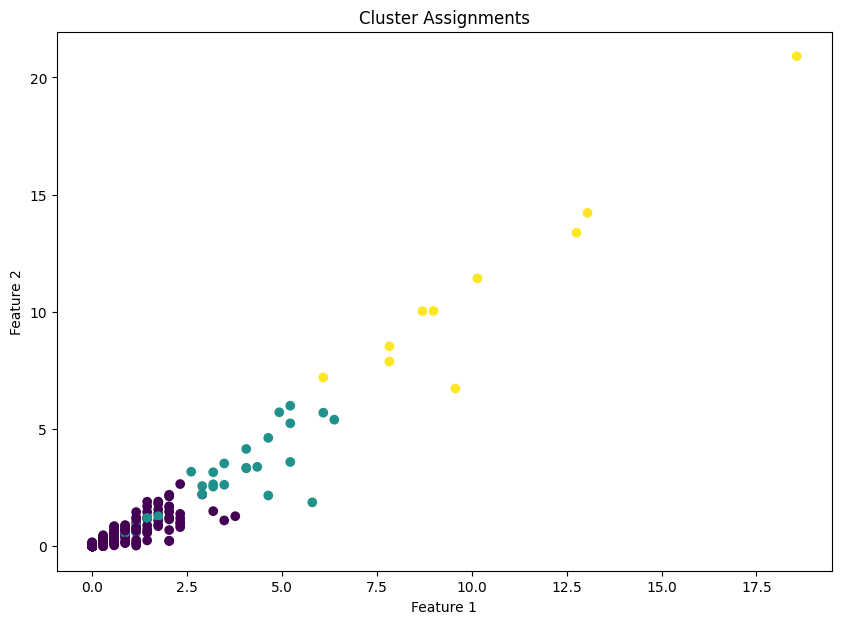

In [ ]:

# DBSCAN Implementation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.clustering import KMeans

# Clustering with KMeans as an alternative to DBSCAN
kmeans = KMeans(k=3, seed=1, featuresCol="features_scaled", predictionCol="cluster")
model = kmeans.fit(scaled_data)
clusters = model.transform(scaled_data)

clusters.select("Gnrc_Name", "cluster").show(10)

# Visualization preparation
import pandas as pd
import matplotlib.pyplot as plt
pandas_df = clusters.select("Gnrc_Name", "features_scaled", "cluster").toPandas()

# Visualizing clusters
plt.figure(figsize=(10, 7))
plt.scatter(pandas_df["features_scaled"].apply(lambda x: x[0]),
            pandas_df["features_scaled"].apply(lambda x: x[1]),
            c=pandas_df["cluster"], cmap="viridis")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Cluster Assignments")
plt.show()


# Interpretation
The visualization shows three distinct clusters, indicating that the drugs have been grouped based on their feature similarities.

# Anomaly Detection Using Isolation Forest

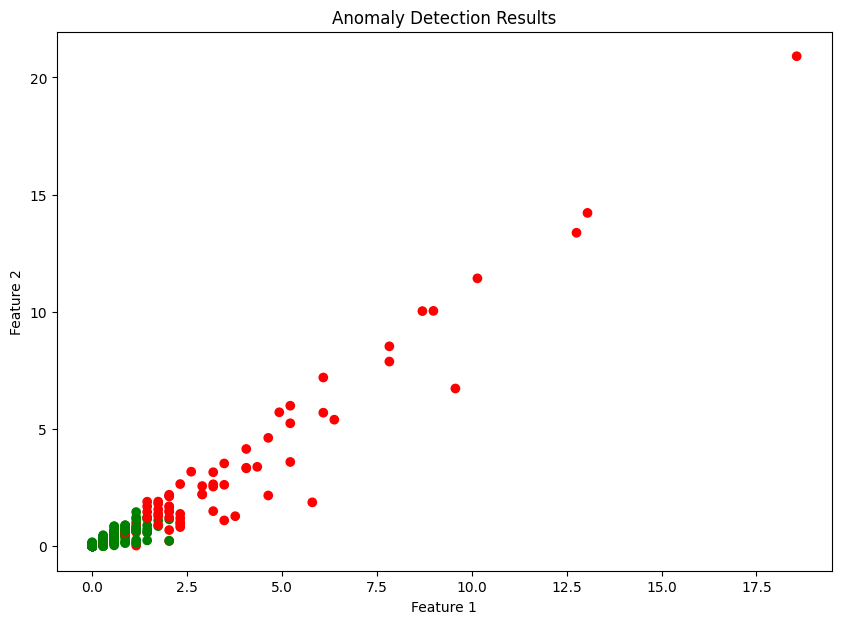

In [ ]:

# Isolation Forest for Anomaly Detection
from pyspark.sql.functions import col
from sklearn.ensemble import IsolationForest

# Converting Spark DataFrame to Pandas for use with IsolationForest
features_pd = scaled_data.select("features_scaled").toPandas()
feature_array = features_pd["features_scaled"].apply(lambda x: [x[i] for i in range(len(x))]).tolist()

# Applying Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = iso_forest.fit_predict(feature_array)

# Adding anomaly predictions to the DataFrame
pandas_df["anomaly"] = anomalies
pandas_df["anomaly"] = pandas_df["anomaly"].apply(lambda x: "Anomaly" if x == -1 else "Normal")

# Visualize anomalies
plt.figure(figsize=(10, 7))
plt.scatter(pandas_df["features_scaled"].apply(lambda x: x[0]),
            pandas_df["features_scaled"].apply(lambda x: x[1]),
            c=pandas_df["anomaly"].map({"Anomaly": "red", "Normal": "green"}))
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Anomaly Detection Results")
plt.show()


# Interpretation

*   Red Points: Identified anomalies (outliers)
*   Green Points: Normal data points.

The plot shows that anomalies are distributed away from the cluster of normal points.



# Simulating Labels for Supervised Learning

In [ ]:

# Simulating Labels for Supervised Learning
import numpy as np
from pyspark.sql.functions import col

# Adding a simulated label column for demonstration (1 = Fraud, 0 = Not Fraud)
# This simulates labels for a binary classification task
np.random.seed(42)
label_data = scaled_data.withColumn("label", col("total_drug_cost_millions") > 500)
label_data = label_data.withColumn("label", label_data["label"].cast("integer"))
label_data.show(5)


+--------------------+--------------------------+-------------------------+------------------------+---------+-------+---------+------------------+--------------------+--------------------+-------------------+--------------------+-----+
|           Gnrc_Name|total_claim_count_millions|total_day_supply_millions|total_drug_cost_millions|max_claim|max_day| max_cost|         var_claim|             var_day|            var_cost|       features_raw|     features_scaled|label|
+--------------------+--------------------------+-------------------------+------------------------+---------+-------+---------+------------------+--------------------+--------------------+-------------------+--------------------+-----+
|Atorvastatin Calcium|                      64.0|                   4635.0|                   842.0|    15390| 473095| 403073.3| 57025.80972718224|2.7869601422890836E8|1.1972733473461762E7|[64.0,4635.0,842.0]|[18.5605182978042...|    1|
| Amlodipine Besylate|                      45.0|   

# Preparing Data for Supervised Learning

## Class Weight Calculation to address Class Imbalance

In [ ]:
from pyspark.sql.functions import col, lit, when, sum as spark_sum

# Calculate class counts using PySpark
class_counts_df = label_data.groupBy("label").count()

# Add total count as a constant column for all rows
total_count = label_data.count()
class_counts_df = class_counts_df.withColumn("total_count", lit(total_count))

# Calculate class weights (total_count / class_count)
class_counts_df = class_counts_df.withColumn(
    "class_weight", col("total_count") / col("count")
)

# Collect weights into a dictionary for reference
class_weights = {row["label"]: row["class_weight"] for row in class_counts_df.collect()}


## Adding Class Weights to the Dataset

In [ ]:
# Broadcast the weights and add them to the dataset
label_data_with_weights = label_data.join(
    class_counts_df.select("label", "class_weight"), on="label", how="left"
)


In [ ]:
print(f"Class Weights: {class_weights}")


Class Weights: {1: 22.818181818181817, 0: 1.0458333333333334}


## Data Preparation and Splitting

In [ ]:
final_data = label_data_with_weights.withColumnRenamed("features_scaled", "features").select(
    "features", "label", "class_weight"
)

# Split data into training and testing
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)




# Training a Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Train Random Forest with weights
rf = RandomForestClassifier(featuresCol="features", labelCol="label", weightCol="class_weight", numTrees=20, seed=42)
rf_model_weighted = rf.fit(train_data)


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Make predictions and evaluate
rf_predictions_weighted = rf_model_weighted.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
roc_auc_weighted = evaluator.evaluate(rf_predictions_weighted)

print(f"ROC-AUC for Weighted Random Forest: {roc_auc_weighted:.2f}")


ROC-AUC for Weighted Random Forest: 1.00


# Visualizing Feature Importances

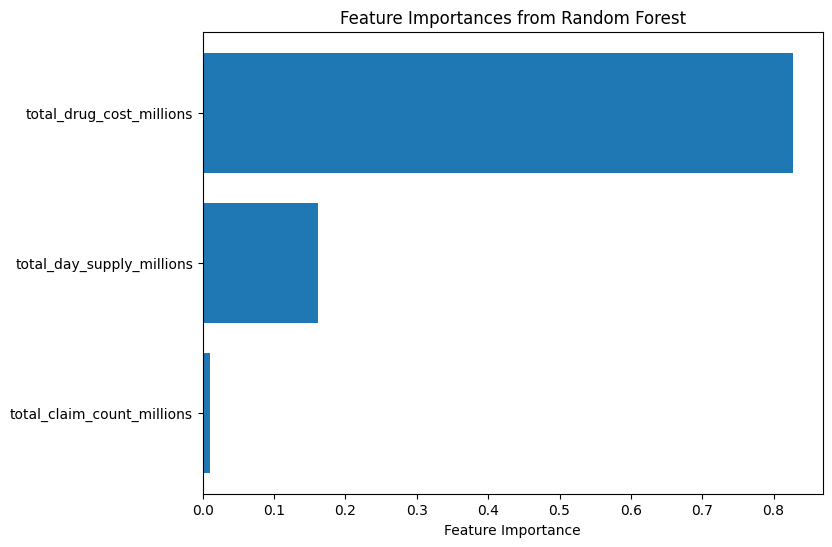

In [ ]:

# Visualizing Feature Importances
import matplotlib.pyplot as plt

# Extracting feature importances from the Random Forest model
importances = rf_model_weighted.featureImportances.toArray()
feature_names = ["total_claim_count_millions", "total_day_supply_millions", "total_drug_cost_millions"]

# Plotting
plt.figure(figsize=(8, 6))
plt.barh(feature_names, importances, align="center")
plt.xlabel("Feature Importance")
plt.title("Feature Importances from Random Forest")
plt.show()


# Interpretation

The total drug costs has been the most important feature for predicting fraud based on the above plot

# Gradient Boosting, Model Evaluation, and Misclassification Analysis


## Gradient Boosting for Fraud Detection

In [ ]:

# Optional: Gradient Boosting (XGBoost)
from pyspark.ml.classification import GBTClassifier

# Training Gradient Boosted Trees
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=50, seed=42)
gbt_model = gbt.fit(train_data)

# Evaluating GBT Model
gbt_predictions = gbt_model.transform(test_data)
roc_auc_gbt = evaluator.evaluate(gbt_predictions)

print(f"ROC-AUC for Gradient Boosted Trees: {roc_auc_gbt:.2f}")

# Displaying a few predictions
gbt_predictions.select("features", "label", "prediction", "probability").show(5)


ROC-AUC for Gradient Boosted Trees: 1.00


+---------+-----+----------+--------------------+
| features|label|prediction|         probability|
+---------+-----+----------+--------------------+
|(3,[],[])|    0|       0.0|[0.97847911444165...|
|(3,[],[])|    0|       0.0|[0.97847911444165...|
|(3,[],[])|    0|       0.0|[0.97847911444165...|
|(3,[],[])|    0|       0.0|[0.97847911444165...|
|(3,[],[])|    0|       0.0|[0.97847911444165...|
+---------+-----+----------+--------------------+
only showing top 5 rows



## Model Evaluation (Precision, Recall, F1-Score)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Precision and Recall
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

precision = evaluator_precision.evaluate(rf_predictions_weighted)
recall = evaluator_recall.evaluate(rf_predictions_weighted)

# F1-Score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", metricName="f1")
f1_score = evaluator_f1.evaluate(rf_predictions_weighted)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")


Precision: 0.99
Recall: 0.99
F1-Score: 0.99


## Confusion Matrix

In [ ]:
# Confusion Matrix
rf_predictions_weighted.groupBy("label", "prediction").count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|  286|
|    1|       1.0|   15|
|    0|       1.0|    3|
+-----+----------+-----+



## Misclassification Analysis

In [ ]:
# Misclassifications
misclassified = rf_predictions_weighted.filter(rf_predictions_weighted["label"] != rf_predictions_weighted["prediction"])
misclassified.select("features", "label", "prediction", "probability").show(5)


+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|[0.0,0.0135311031...|    0|       1.0|[0.20603971551616...|
|[0.0,0.0180414709...|    0|       1.0|[0.24690364923413...|
|[0.0,0.0360829418...|    0|       1.0|[0.39305078275443...|
+--------------------+-----+----------+--------------------+



# Visualizing Label Distribution

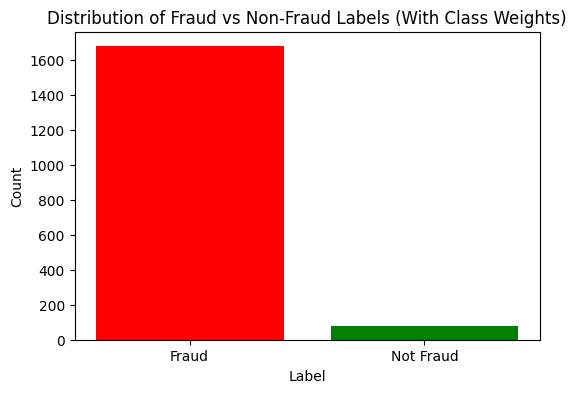

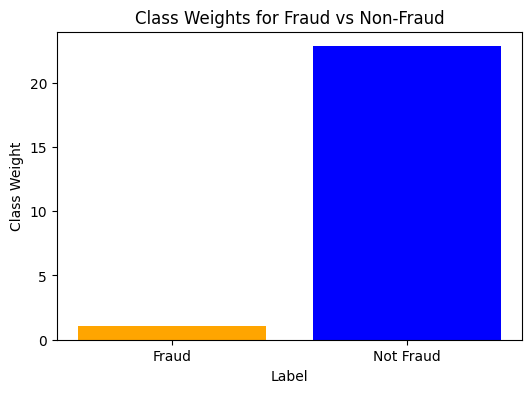

In [ ]:
import matplotlib.pyplot as plt

# Counting labels
label_counts = label_data_with_weights.groupBy("label").count().toPandas()

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(label_counts["label"], label_counts["count"], color=["green", "red"], tick_label=["Not Fraud", "Fraud"])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Fraud vs Non-Fraud Labels (With Class Weights)")
plt.show()

# Extracting class weights for visualization
weights_df = label_data_with_weights.groupBy("label").agg({"class_weight": "first"}).toPandas()

# Plotting class weights
plt.figure(figsize=(6, 4))
plt.bar(weights_df["label"], weights_df["first(class_weight)"], color=["blue", "orange"], tick_label=["Not Fraud", "Fraud"])
plt.xlabel("Label")
plt.ylabel("Class Weight")
plt.title("Class Weights for Fraud vs Non-Fraud")
plt.show()


# Interpretation

1.   Top Plot – Distribution of Fraud vs Non-Fraud Labels:

  *   Highlights the imbalance in the dataset, with the Fraud class having far more samples compared to the Not Fraud class.


2.   Bottom Plot – Class Weights:

  *   Demonstrates the adjusted class weights:
Higher weight for Not Fraud to balance its lower representation.
Lower weight for Fraud due to its higher representation.











# Feature Relationships by Label Using Pairplot

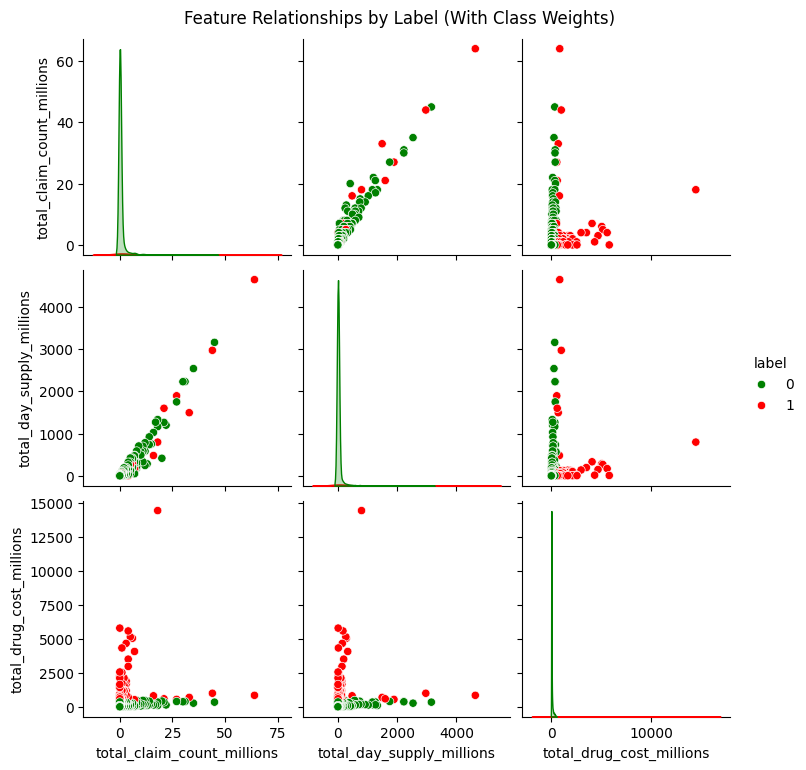

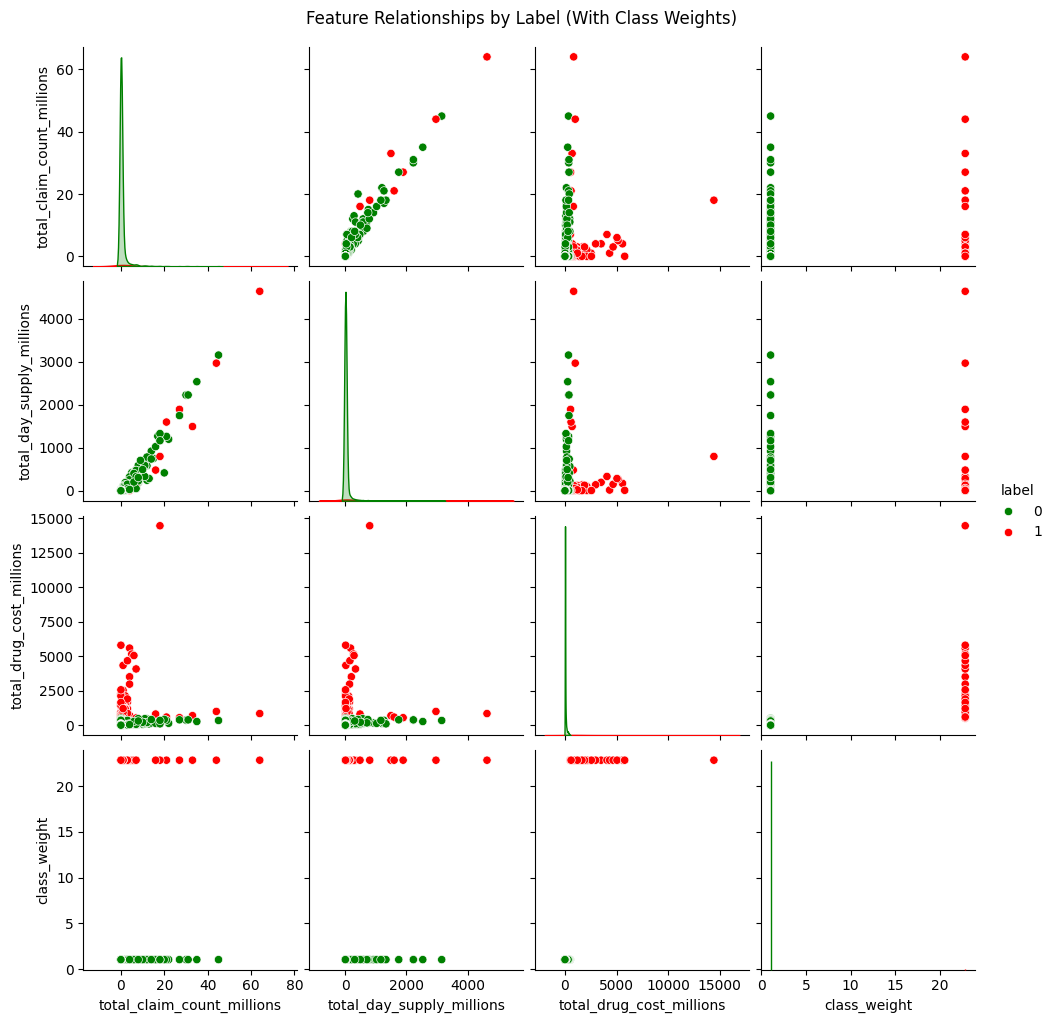

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert the data to Pandas for visualization
pandas_data = label_data_with_weights.select(
    "total_claim_count_millions",
    "total_day_supply_millions",
    "total_drug_cost_millions",
    "label"
).toPandas()

# Pairplot with updated data
sns.pairplot(pandas_data, hue="label", diag_kind="kde", palette={0: "green", 1: "red"})
plt.suptitle("Feature Relationships by Label (With Class Weights)", y=1.02)
plt.show()

# Convert the data to Pandas for visualization, including class weights
pandas_data_with_weights = label_data_with_weights.select(
    "total_claim_count_millions",
    "total_day_supply_millions",
    "total_drug_cost_millions",
    "label",
    "class_weight"
).toPandas()

# Pairplot with class weights
sns.pairplot(pandas_data_with_weights, hue="label", diag_kind="kde", palette={0: "green", 1: "red"})
plt.suptitle("Feature Relationships by Label (With Class Weights)", y=1.02)
plt.show()


# Interpretation



1.   Top plot:
It shows how the features relate to each other, with fraud cases clearly distinguished from non-fraud cases:

  *   Fraud cases (red) tend to have higher values in total_drug_cost_millions.
  *   Non-fraud cases (green) cluster in lower-value regions.
2.   Bottom plot: It highlights the distribution of fraud and non-fraud cases, taking class weights into account.

  *   Fraud cases have a lower class weight compared to non-fraud cases.
  *   The class weights help balance the model by giving higher importance to the minority class during training.






# Visualizing Feature Distributions  based on binary labels with Boxplots

Unique labels: ['1' '0']


/var/folders/sf/0xjrr9295rbcr7jkyvcdpq300000gn/T/ipykernel_33559/4041052726.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sf/0xjrr9295rbcr7jkyvcdpq300000gn/T/ipykernel_33559/4041052726.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/sf/0xjrr9295rbcr7jkyvcdpq300000gn/T/ipykernel_33559/4041052726.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




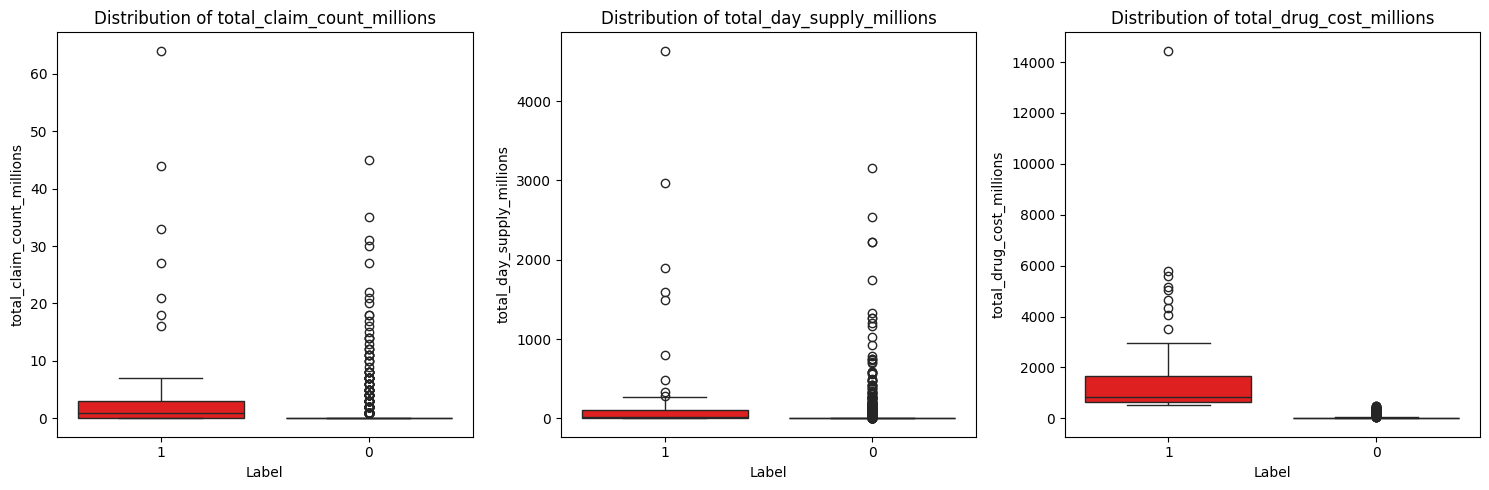

In [ ]:
# Ensure 'label' is numeric and check its unique values
pandas_data_with_weights["label"] = pandas_data_with_weights["label"].astype(str)  # Convert to string
print("Unique labels:", pandas_data_with_weights["label"].unique())  # Verify label values

# Define palette with keys matching the string label values
palette = {"0": "green", "1": "red"}

# Features to plot
features = ["total_claim_count_millions", "total_day_supply_millions", "total_drug_cost_millions"]

# Boxplot for Feature Distributions
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features, start=1):
    plt.subplot(1, 3, i)
    sns.boxplot(x="label", y=feature, data=pandas_data_with_weights, palette=palette)
    plt.title(f"Distribution of {feature}")
    plt.xlabel("Label")
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


# Interpretation


*   Fraud cases (red) have higher claim counts compared to non-fraud cases
*   Fraud cases show a wider spread and has more outliers
*   Fraud cases have significantly higher drug costs compared to non-fraud cases





# Correlation Heatmap

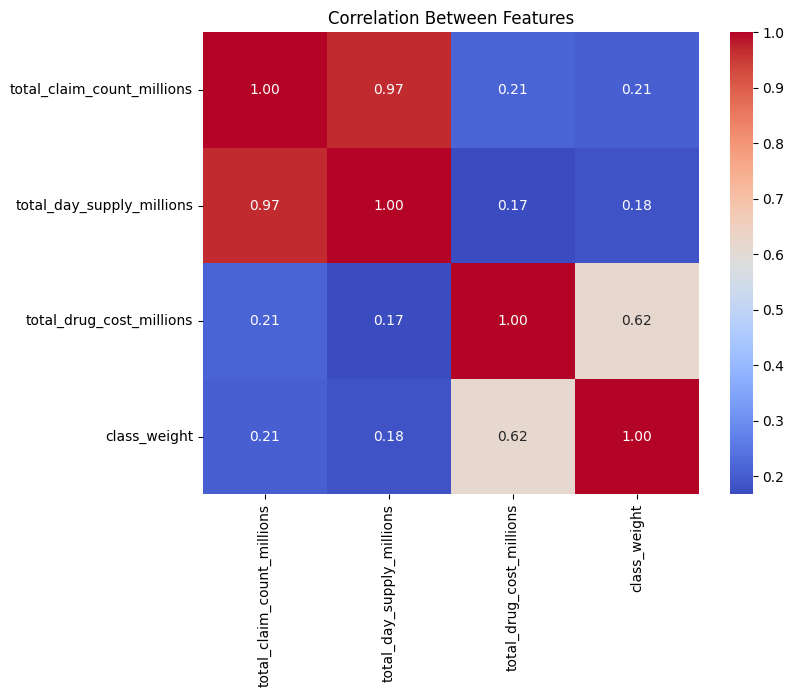

In [ ]:

# Correlation Heatmap
correlation_matrix = pandas_data_with_weights.drop("label", axis=1).corr()

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Features")
plt.show()


# Interpretation

*   Strong Positive Correlation: total_claim_count_millions and total_day_supply_millions have a very high positive correlation (0.97) which indicates that as the claim count increases, the day supply tends to increase.

*    Moderate Positive Correlation: total_drug_cost_millions and class_weight have a moderate positive correlation (0.62) which indicates that as the class weights are influenced by total drug costs, due to the need to balance the model for high cost claims.
*   Weak Correlation: class_weight and total_claim_count_millions have a low correlation of (0.21) which shows that class weights are not strongly influenced by the number of claims alone.

*   Weak Correlation:total_day_supply_millions and class_weight shows weak correlation of (0.18) which iImplies minimal direct relationship between total day supply and class weights.




# Installing Tensorflow

In [ ]:

!pip3 install tensorflow



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip


# Anomaly Detection Using Autoencoder


In [ ]:

# Autoencoder for Anomaly Detection
from pyspark.sql.functions import col
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np

# Prepare the data
features_pd = scaled_data.select("features_scaled").toPandas()
feature_array = features_pd["features_scaled"].apply(lambda x: np.array(x)).tolist()
feature_array = np.array(feature_array)

# Autoencoder Architecture
input_dim = feature_array.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(16, activation="relu")(input_layer)
encoder = Dense(8, activation="relu")(encoder)
encoder = Dense(4, activation="relu")(encoder)
decoder = Dense(8, activation="relu")(encoder)
decoder = Dense(16, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the Autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
autoencoder.summary()

# Train the Autoencoder
history = autoencoder.fit(feature_array, feature_array,
                          epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Reconstruction Errors
reconstructions = autoencoder.predict(feature_array)
mse = np.mean(np.square(reconstructions - feature_array), axis=1)

# Set an anomaly threshold (e.g., mean + 2*std)
threshold = mse.mean() + 2 * mse.std()
print(f"Anomaly Detection Threshold: {threshold:.4f}")

# Identify anomalies
anomalies = mse > threshold
features_pd["anomaly"] = anomalies.astype(int)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 471 (1.84 KB)

 Trainable params: 471 (1.84 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4089 - val_loss: 0.1166
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3145 - val_loss: 0.1015
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 0.6816 - val_loss: 0.0787
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 0.5029 - val_loss: 0.0727
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.2616 - val_loss: 0.0542
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.1233 - val_loss: 0.0342
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 0.1172 - val_loss: 0.0189
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0504 - val_loss: 0.0106
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 0.0215 - val_loss: 0.0071
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0166 - val_loss: 0.0061
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - loss: 0.0143 - val_loss: 0.0054
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - l

# Visualization of Reconstruction Error

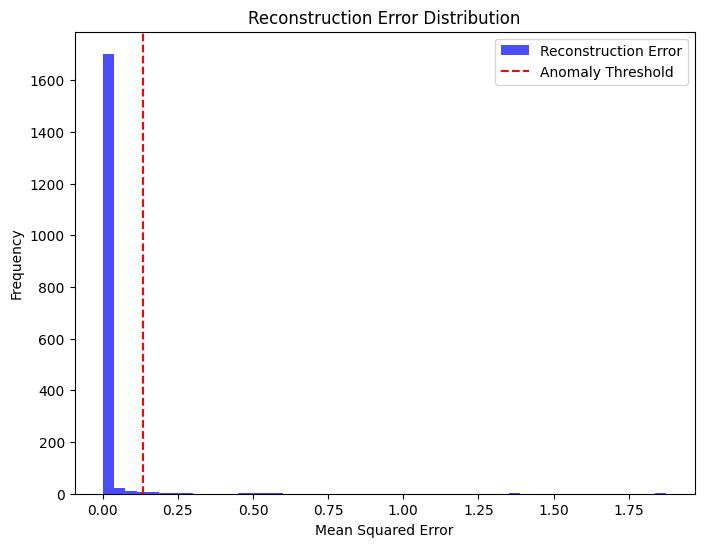

In [ ]:
import matplotlib.pyplot as plt

# Plotting reconstruction error distribution
plt.figure(figsize=(8, 6))
plt.hist(mse, bins=50, alpha=0.7, color='blue', label="Reconstruction Error")
plt.axvline(threshold, color='red', linestyle='--', label="Anomaly Threshold")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Mean Squared Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Interpretation

*   Most of the data points have low reconstruction errors, falling to the left of the threshold.
*   Data points to the right of the red line have reconstruction errors exceeding the threshold and are flagged as anomalies.



# Analyzing the Anomalies Detected

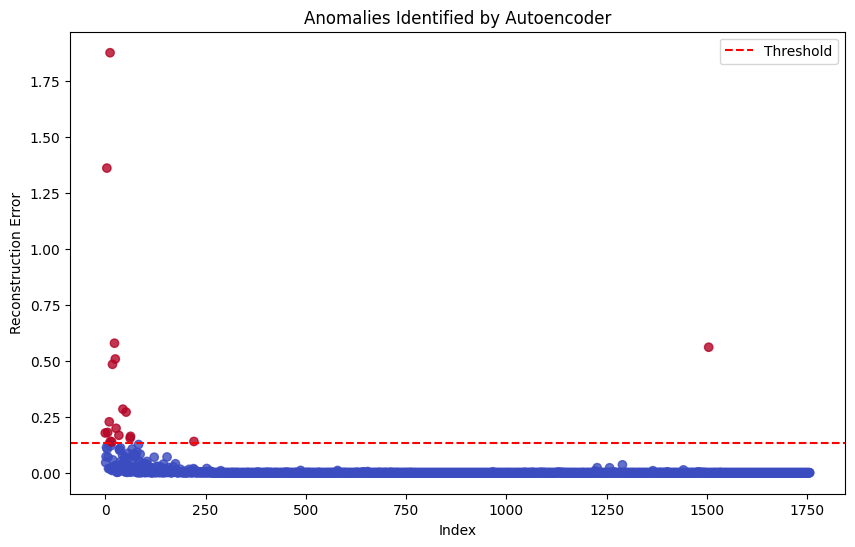

In [ ]:


import pandas as pd

# Adding anomaly results to the dataset
anomalies_df = pd.DataFrame(feature_array, columns=["Feature_" + str(i) for i in range(feature_array.shape[1])])
anomalies_df["Anomaly"] = features_pd["anomaly"]

# Visualizing anomalies
plt.figure(figsize=(10, 6))
plt.scatter(anomalies_df.index, mse, c=anomalies_df["Anomaly"], cmap="coolwarm", alpha=0.8)
plt.axhline(y=threshold, color="red", linestyle="--", label="Threshold")
plt.title("Anomalies Identified by Autoencoder")
plt.xlabel("Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.show()


# Interpretation

Anomalies:

*   Points with reconstruction errors significantly higher than the threshold are flagged as anomalies.
*   These points are visually distinct and often outliers compared to the rest of the dataset.

Normal Points:

*   Most data points have low reconstruction errors, clustering below the threshold.